Sumber Data: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

###1. Importing Dependencies

In [ ]:
!pip install pmdarima

import pandas as pd
import numpy as np
from math import sqrt
from pandas import Series

from matplotlib import pyplot
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
from matplotlib.pylab import rcParams

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose #mengakses modul seasonal decompose pada modul time series analysis
from statsmodels.tsa.stattools import adfuller # mengakses function Augmented Dickey-Fuller unit root test.
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA  # mengakses function ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import sys
import itertools

import seaborn as sns
%matplotlib inline

###2. Uploading Data

In [ ]:
data = pd.read_csv('/content/oil.csv')
data.head

<bound method NDFrame.head of            date  dcoilwtico
0    2016-07-01       49.02
1    2016-07-04         NaN
2    2016-07-05       46.73
3    2016-07-06       47.37
4    2016-07-07       45.22
..          ...         ...
300  2017-08-25       47.65
301  2017-08-28       46.40
302  2017-08-29       46.46
303  2017-08-30       45.96
304  2017-08-31       47.26

[305 rows x 2 columns]>

###3. Data Exploration

In [ ]:
# Menampilkan nama kolom
data.columns

Index(['date', 'dcoilwtico'], dtype='object')

In [ ]:
# Menampilkan info dari tiap variable
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        305 non-null    object 
 1   dcoilwtico  294 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.9+ KB


In [ ]:
# Mencari missing value
print(data.isnull().sum())

date           0
dcoilwtico    11
dtype: int64


> **Insights:**
*   Terdapat 11 missing values pada kolom dcoilwtico / Daily Oil Price
*   Missing values akan diatasi dengan backfill agar data tetap stabil



In [ ]:
# Mengatasi missing value dengan backfill
updated_data = data
updated_data['dcoilwtico']=updated_data['dcoilwtico'].fillna(updated_data['dcoilwtico'].bfill())
updated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        305 non-null    object 
 1   dcoilwtico  305 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.9+ KB


In [ ]:
# Pada kolom date, ubah tipe data menjadi datetime
data['date']=pd.to_datetime(data['date'], infer_datetime_format=True)

# Cek tipe data
print (data.dtypes)

date          datetime64[ns]
dcoilwtico           float64
dtype: object


In [ ]:
# Set kolom 'date' sebagai index
data.date = pd.to_datetime(data.date)
data = data.set_index("date")
data.head()

,dcoilwtico
date,
2016-07-01,49.02
2016-07-04,46.73
2016-07-05,46.73
2016-07-06,47.37
2016-07-07,45.22


In [ ]:
# Summary statistics pada variabel 'dcoilwtico'
print (data.describe().T)
print ('---------')

# Pembulatan decimal 2 angka di belakang koma
print(data.describe().T.round(2))

            count       mean       std   min    25%    50%    75%    max
dcoilwtico  305.0  48.296295  3.366872  39.5  45.69  48.13  50.99  54.48
---------
            count  mean   std   min    25%    50%    75%    max
dcoilwtico  305.0  48.3  3.37  39.5  45.69  48.13  50.99  54.48


###4. Data Analysis

Pada bagian ini, kita akan melakukan visualisasi data ke dalam bentuk grafik yang disebut Time-series Plot. Tujuannya untuk memudahkan kita menemukan pattern atau pola dan temuan yang tidak biasa dari dataset dcoilwtico.

####4.1 Time-series Plot

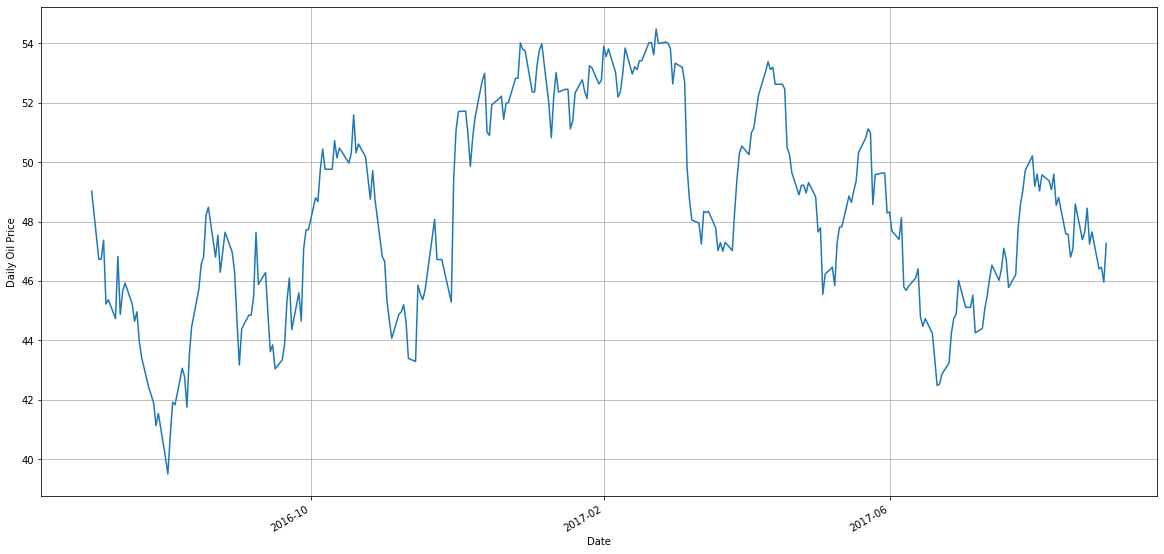

In [ ]:
# Time Series plot

import matplotlib.dates as mdates
import matplotlib.pyplot as plty

fig, ax = plty.subplots(figsize=(20,10))
plty.xlabel("Date")
plty.ylabel("Daily Oil Price")

half_year_locator = mdates.MonthLocator(interval = 4)
year_month_formatter = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter)

ax.plot(data)
fig.autofmt_xdate()
plty.grid()
plty.show()

> **Insights:**
*   Kita menemukan pola yang tidak biasa dari datase dcoilwtico. Harga minyak dapat disimpulkan tidak stabil karena mengalami kenaikan dan penurunan secara drastis.
*   Lalu kita coba cek menggunakan seasonal plot untuk melihat lebih jelas melalui bantuan package seaborn dan membuat dataframe sementara (variabel: data2) untuk membuat visualisasi seasonal plot.



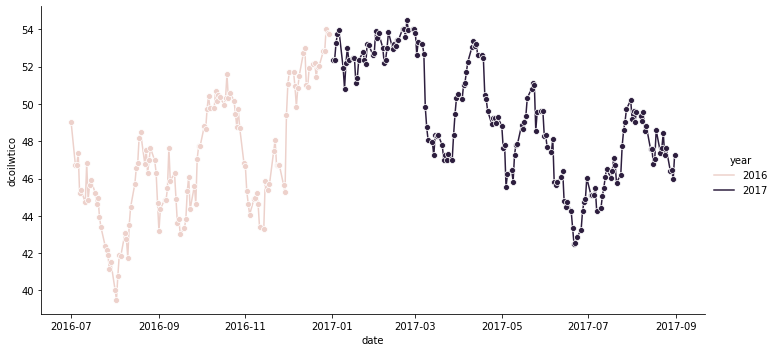

In [ ]:
# Seasonal plot

data2 = data.reset_index()
data2['year'] = pd.DatetimeIndex(data2['date']).year
data2['month'] = pd.DatetimeIndex(data2['date']).month

# parameter hue digunakan untuk menampilkan multiple line chart berdasarkan tahun ('year')
sns.relplot (kind = 'line', data = data2, x = 'date', y = 'dcoilwtico', hue = 'year', aspect = 2, marker='o' )

Selanjutnya, kita melakukan uji statistik (statistical test) dengan Dickey-Fuller tes untuk melakukan konfirmasi apakah data yang dimiliki merepresentasikan bentuk stasioner.

#### 4.2 Stationarity Check - Rolling Statistic test

In [ ]:
# rolling dengan interval window sebesar 12 bulan dan hitung rata-rata
rolmean=data.rolling(window=12).mean()

# rolling dengan interval window sebesar 12 bulan dan hitung st. deviasi
rolstd=data.rolling(window=12).std()

# Tampilkan 15 baris pertama dari hasil rolling mean
print('15 baris pertama rolling mean: ')
print(rolmean.head(15))
print ('')

# Tampilkan 15 baris pertama dari hasil rolling st. deviasi
print('15 baris pertama std. deviasi: ')
print(rolstd.head(15))

15 baris pertama rolling mean: 
            dcoilwtico
date                  
2016-07-01         NaN
2016-07-04         NaN
2016-07-05         NaN
2016-07-06         NaN
2016-07-07         NaN
2016-07-08         NaN
2016-07-11         NaN
2016-07-12         NaN
2016-07-13         NaN
2016-07-14         NaN
2016-07-15         NaN
2016-07-18   46.138333
2016-07-19   45.773333
2016-07-20   45.625833
2016-07-21   45.395000

15 baris pertama std. deviasi: 
            dcoilwtico
date                  
2016-07-01         NaN
2016-07-04         NaN
2016-07-05         NaN
2016-07-06         NaN
2016-07-07         NaN
2016-07-08         NaN
2016-07-11         NaN
2016-07-12         NaN
2016-07-13         NaN
2016-07-14         NaN
2016-07-15         NaN
2016-07-18    1.247848
2016-07-19    0.927885
2016-07-20    0.902315
2016-07-21    0.947355


Lalu, kita akan visualisasikan dari hasil rolling mean dan rolling std. deviasi untuk mengecek apakah apakah series ini stasioner atau tidak melalui bentuk visual grafik di bawah.

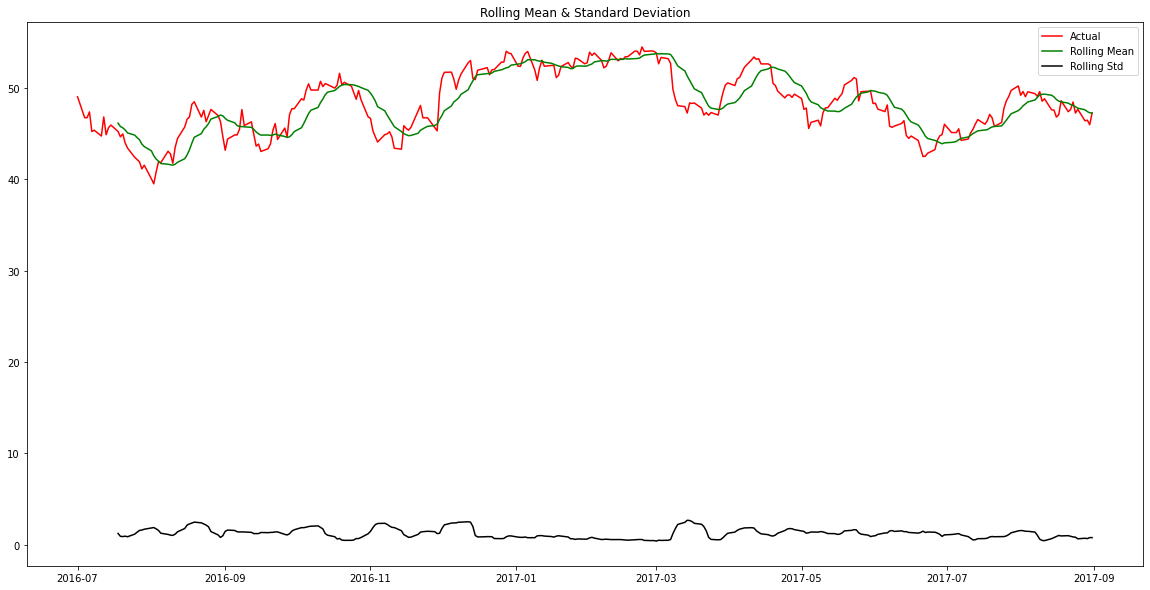

In [ ]:
# atur ukuran chart
plt.figure(figsize=(20,10))

# buat multiple line chart berdasarkan warna dan label
actual=plt.plot(data, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean')
std_6=plt.plot(rolstd, color='black', label='Rolling Std')

# tampilkan legend, judul dari chart, dan panggil function untuk menampilkan chart
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

> **Insights:**
*    Dari grafik di atas kita dapat melihat bahwa data aktual dan rolling (mean dan std) memiliki bentuk yang cukup berbeda, menandakan bahwa series ini **tidak stasioner**.



#### 4.3 Stationarity Check - Augmented Dickey-Fuller (ADF) test

* Selanjutnya, kita akan gunakan ADF test untuk uji stasioner dimana:

  **H0:** *The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.*

 **H1:** *The time series is stationary.*

* Jika p-value test kurang dari significance level (contoh alpha = 0.05) dan nilai ADF test lebih kecil dibandingkan critical values maka kita dapat reject null hypothesis dan dapat menyimpulkan bahwa time series adalah stasioner.

In [ ]:
# menggunakan function adfuller() yang diterapkan pada variable dcoilwtico
print('Dickey-Fuller Test: ')
dftest=adfuller(data['dcoilwtico'], autolag='AIC')
dftest

Dickey-Fuller Test: 


(-2.389944379572642,
 0.1445946703677291,
 0,
 304,
 {'1%': -3.452045317832011,
  '10%': -2.571860921485457,
  '5%': -2.871094805558846},
 754.6673774785448)

In [ ]:
# Supaya hasil uji lebih nyaman dibaca, maka kita buat series berdasarkan index
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])

# Gunakan for loop untuk menaruh value dari dictionary dengan function items()
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print('Dickey-Fuller Test: ')
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic           -2.389944
p-value                   0.144595
Lags Used                 0.000000
No. of Obs              304.000000
Critical Value (1%)      -3.452045
Critical Value (5%)      -2.871095
Critical Value (10%)     -2.571861
dtype: float64


> **Insights:**

*   Nilai ADF statistic yang jauh lebih besar dari critical values pada semua level, dan juga p-value yang lebih besar dari 0.05 turut menandakan, **kita gagal menolak null hypothesis pada 90%, 95%, dan 99% tingkat keyakinan**, yang **mengindikasikan** bahwa **data time series ini strongly non-stationary.**

*   Berdasarkan insights di atas, maka kita akan mencoba menstabilkan variance dengan cara log transformation pada data dcoilwtico dengan ``` np.log() ```



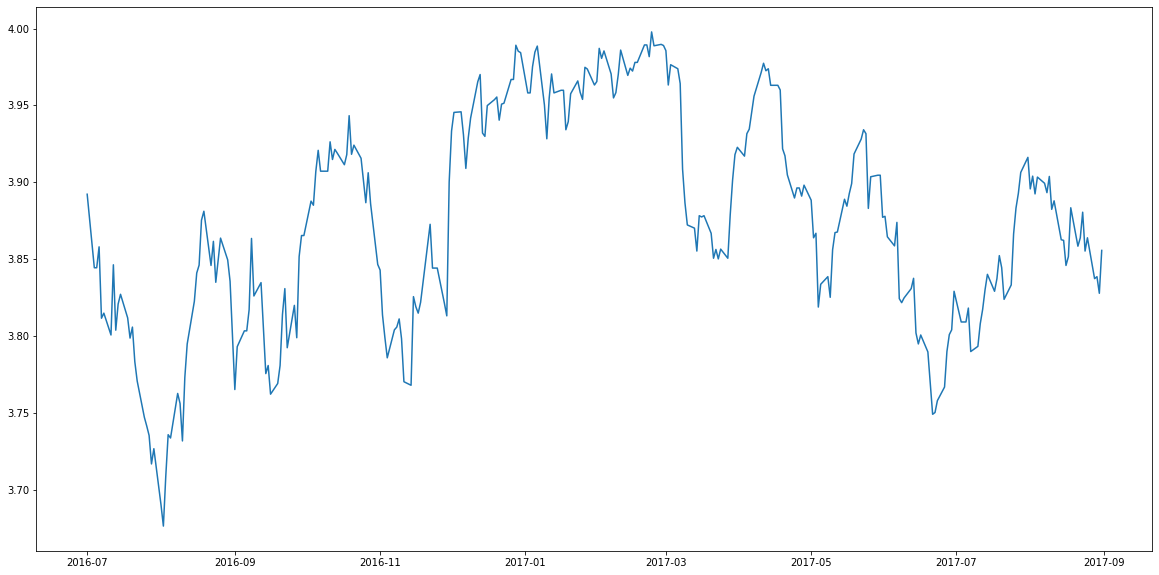

In [ ]:
# Plot dalam bentuk visualisasi line chart dengan menggunakan function numpy np.log
plt.figure(figsize=(20,10))
data_log=np.log(data)
plt.plot(data_log)

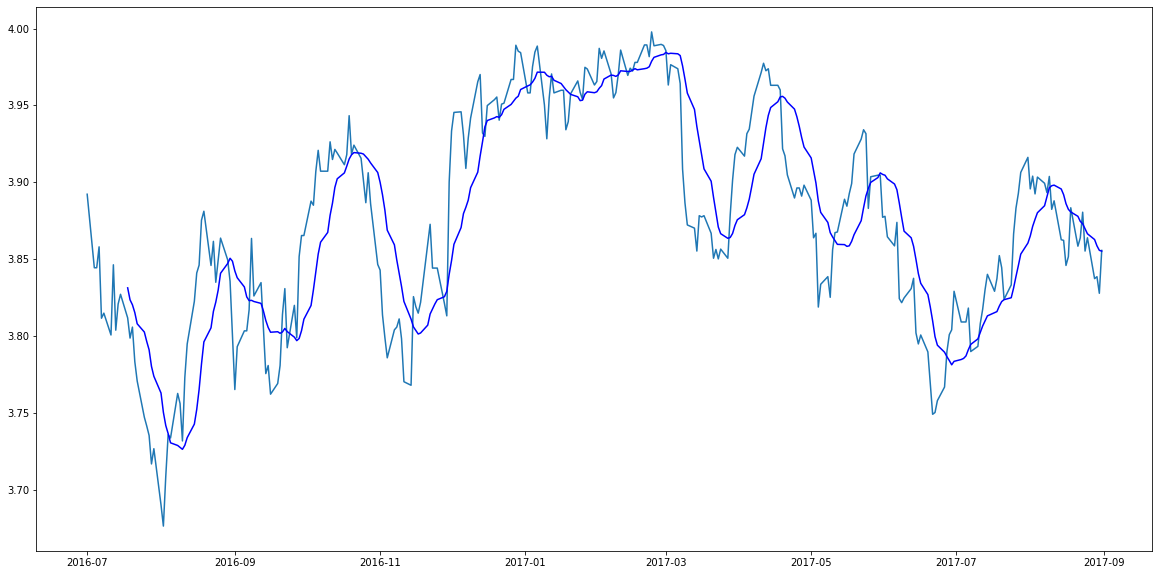

In [ ]:
# Cek secara visual kembali dengan plot data_log dengan rolling window mean dan std. deviation
plt.figure(figsize=(20,10))

MAvg=data_log.rolling(window=12).mean()
MStd=data_log.rolling(window=12).std()

plt.plot(data_log)
plt.plot(MAvg, color='blue')
#plt.plot(MStd, color='red')

In [ ]:
# Hitung difference dari data_log dengan MAvg
data_log_diff=data_log-MAvg

# Tampilkan 12 baris teratas dari data_log_diff
data_log_diff.head(12)

,dcoilwtico
date,
2016-07-01,NaN
2016-07-04,NaN
2016-07-05,NaN
2016-07-06,NaN
2016-07-07,NaN
2016-07-08,NaN
2016-07-11,NaN
2016-07-12,NaN
2016-07-13,NaN


In [ ]:
# Efek dari rolling di atas, maka akan ada value NaN, sehingga kita bisa lakukan dropna()
data_log_diff=data_log_diff.dropna()
data_log_diff.head()

,dcoilwtico
date,
2016-07-18,-0.019553
2016-07-19,-0.024884
2016-07-20,-0.014523
2016-07-21,-0.031924
2016-07-22,-0.037239


In [ ]:
# Buat function stationarity untuk menampilkan multiple line chart dari actual, rolling mean, dan rolling std.deviasi
# yang juga berisikan hasil tes dari Dickey-Fuller

def stationarity(timeseries):

    rolmean=timeseries.rolling(window=12).mean()
    rolstd=timeseries.rolling(window=12).std()

    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean')
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries['dcoilwtico'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

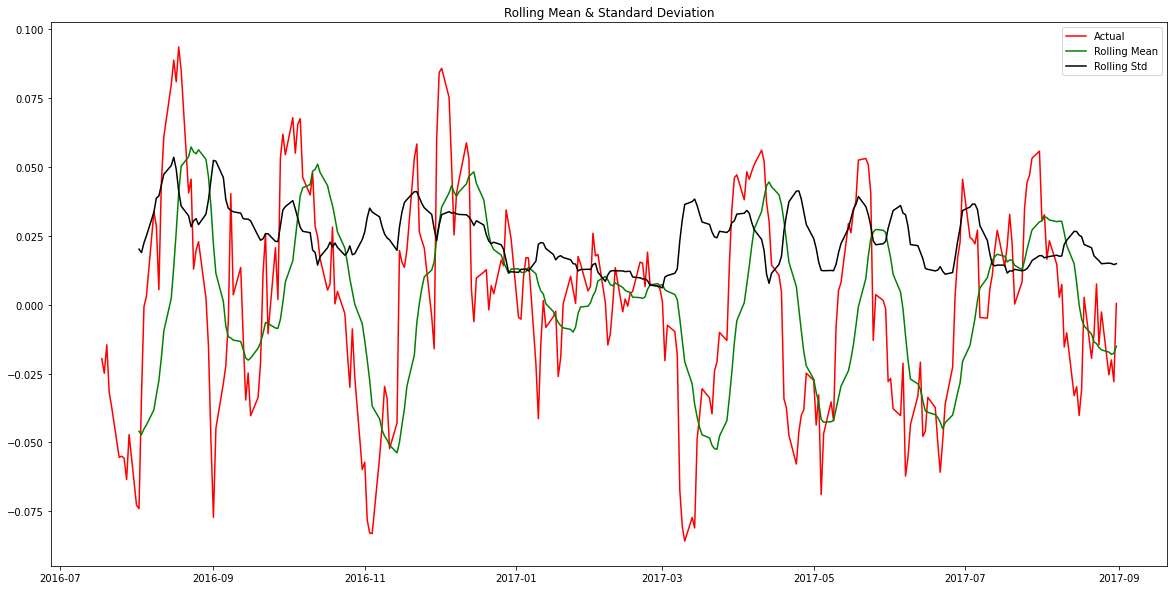

Dickey-Fuller Test: 
Test Statistic           -4.278436
p-value                   0.000484
Lags Used                 0.000000
No. of Obs              293.000000
Critical Value (1%)      -3.452867
Critical Value (5%)      -2.871455
Critical Value (10%)     -2.572053
dtype: float64


In [ ]:
# panggil function dan terapkan pada data_log_diff
stationarity(data_log_diff)

> **Insights:**

* Dapat dilihat dari hasil Dickey-Fuller test ini, bahwa untuk tingkat keyakinan 5% dan 10% sudah menunjukkan series ini stasioner dimana p-value 0.000484 < 0.05 menunjukkan bahwa kita menolak null hypothesis (reject to fail H0, accept H1), dan menyatakan bahwa series ini stasioner.

* Namun, karena `t-value (-4.278436) < DF critical value 10% (-2.572053)` maka, kita menolak null hypothesis (H0) dan menerima H1 yang menyatakan pada series ini stasioner pada tingkat keyakinan 10% (*significance level* of 0.01).

* Selanjutnya, kita aka mencoba menggunakan Exponentially Weighted Moving Average untuk memberi banyak bobot terhadap observasi terbaru

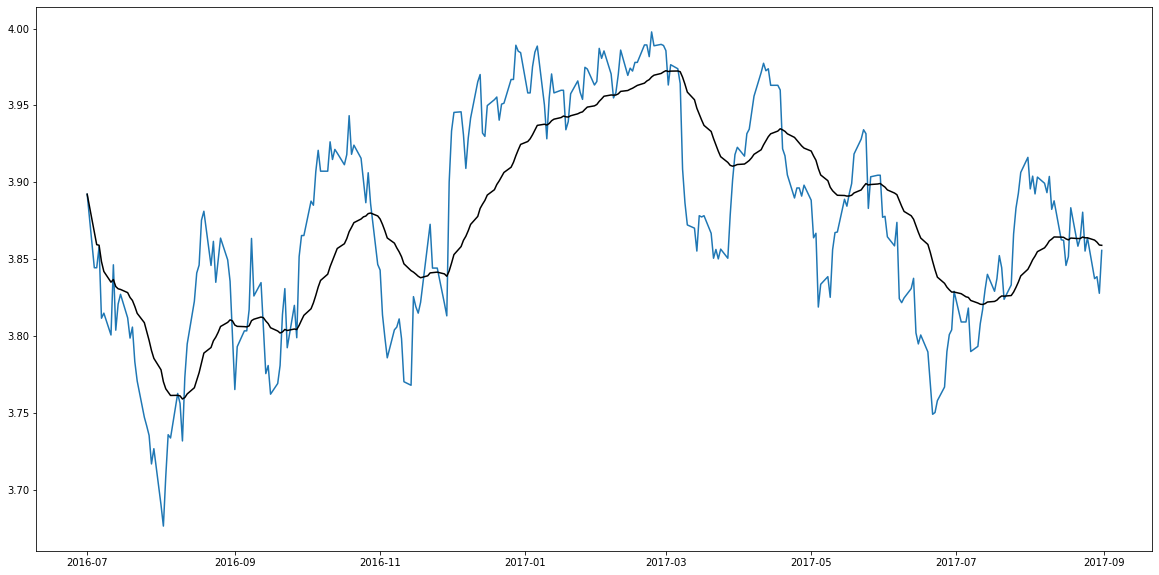

In [ ]:
# Visualisasikan ke dalam bentuk chart
plt.figure(figsize=(20,10))

# Terapkan function ewm pada data_log melalui variable exp_data
exp_data=data_log.ewm(halflife=12, min_periods=0, adjust=True).mean()

plt.plot(data_log)
plt.plot(exp_data, color='black')

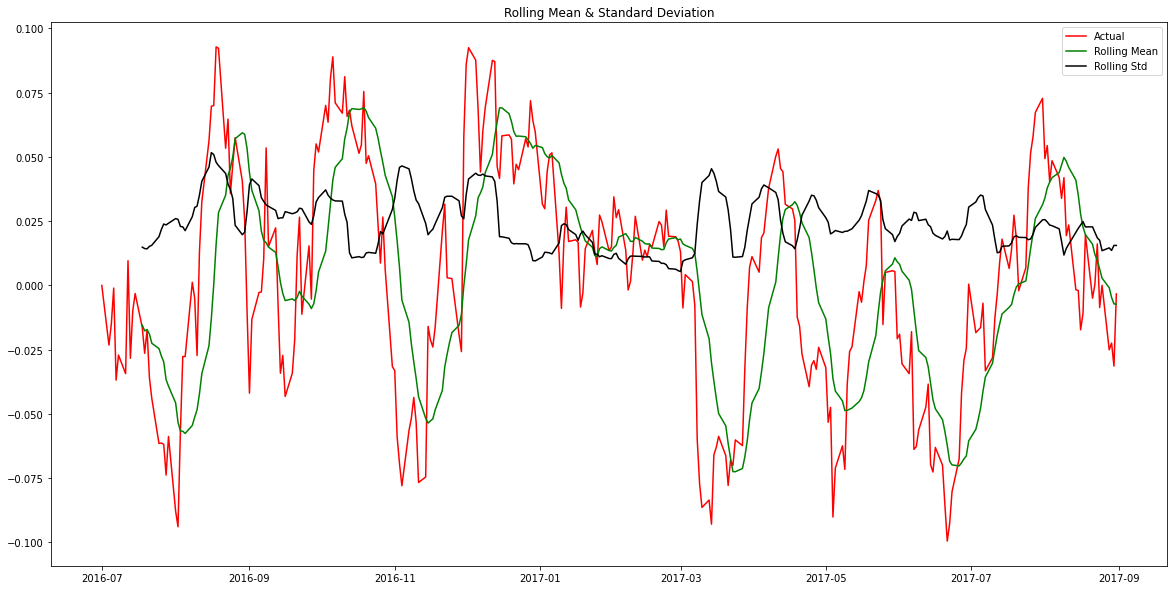

Dickey-Fuller Test: 
Test Statistic           -3.676499
p-value                   0.004456
Lags Used                 0.000000
No. of Obs              304.000000
Critical Value (1%)      -3.452045
Critical Value (5%)      -2.871095
Critical Value (10%)     -2.571861
dtype: float64


In [ ]:
# Hitung difference antara data_log dengan exp_data
exp_data_diff=data_log-exp_data

# Panggil function stationarity dan terapkan pada exp_data_diff
stationarity(exp_data_diff)

> **Insights:**

Sekarang, kita dapat melihat hasil melalui Dickey-Fuller test ini bahwa **nilai t-value (-3.676499) < DF critical value 1% (-3.452045)** maka kita dapat **reject null hypothesis**, dengan 90%, 95%, dan 99% tingkat keyakinan menyatakan bahwa series ini **sudah stasioner**.

###5. Model Development

> Pada Model Development, kita akan mencoba menerapkan 4 model time series yaitu:
1. Holt-Winters
2. SARIMAX (pada dasarnya ini adalah ARIMA, yang memang spesifik untuk menghadapi seasonal effect seperti yg dialami oleh data yg sedang kita olah ini)
3. ARIMA
4. Prophet

Pisahkan data time series menjadi train dan test data

In [ ]:
# Split the data untuk 29 month test
train = data[0:int(len(data)*0.80)]   #train data sebesar 80%
test = data[int(len(data)*0.80):]     #test data sebesar 20%

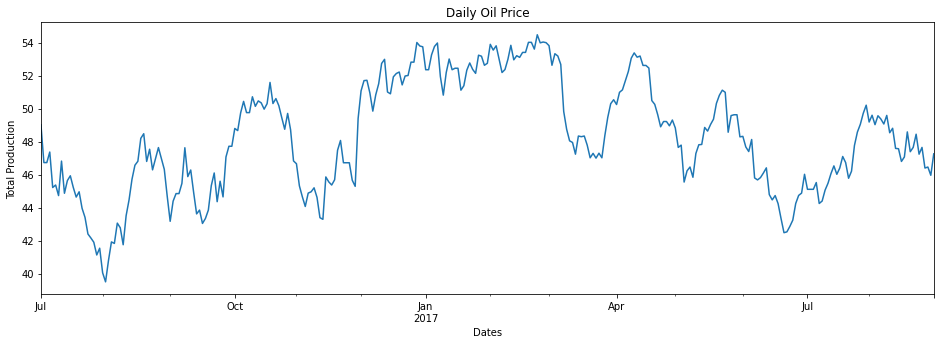

In [ ]:
#Basic Data Plot
data.index = pd.to_datetime(data.index)
ax = data['dcoilwtico'].plot(figsize = (16,5), title = "Daily Oil Price")
ax.set(xlabel='Dates', ylabel='Total Production');

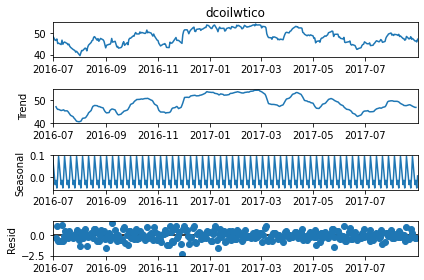

In [ ]:
#Seasonal Decompose Plots
a = seasonal_decompose(data["dcoilwtico"], model = "add")
a.plot();

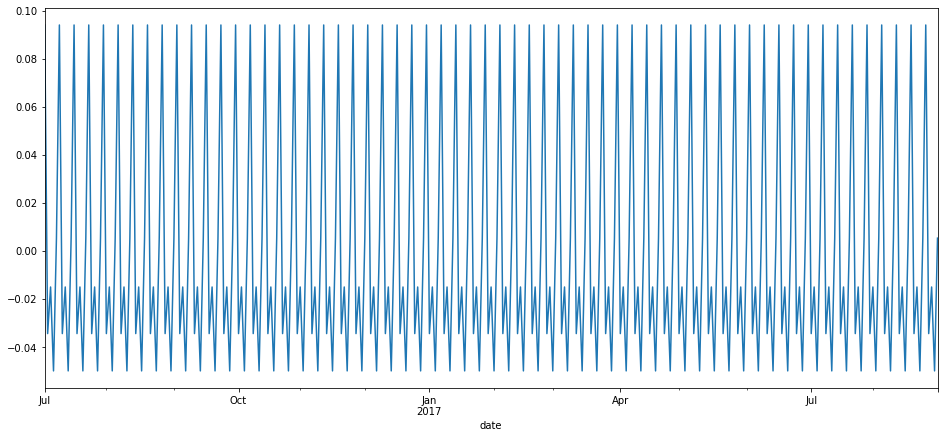

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,7))
a.seasonal.plot();

####5.1 Holt-Winters

In [ ]:
train.head()

,dcoilwtico
date,
2016-07-01,49.02
2016-07-04,46.73
2016-07-05,46.73
2016-07-06,47.37
2016-07-07,45.22


In [ ]:
#MODELING DATA TRAINING
model_data = ExponentialSmoothing(np.asarray(train['dcoilwtico']),seasonal_periods=24, trend='add',seasonal='mul').fit(optimized=True)

In [ ]:
#copy 3 bulan periode (2017-06 - 2017-9) untuk test dan assign ke data_Holt
data_Holt = test.copy()

In [ ]:
len(test['dcoilwtico'])

61

In [ ]:
# FORCESTINGNYA
data_Holt['Holt'] = model_data.forecast(len(test['dcoilwtico']))

In [ ]:
data_Holt.tail()

,dcoilwtico,Holt
date,,
2017-08-25,47.65,45.549696
2017-08-28,46.40,45.785581
2017-08-29,46.46,45.495615
2017-08-30,45.96,45.918288
2017-08-31,47.26,45.479498


In [ ]:
#params untuk mengubah data pada variabel model_data menjadi sebuah dictionary
model_data.params

{'damping_trend': nan,
 'initial_level': 41.759853280179364,
 'initial_seasons': array([1.17388203, 1.181281  , 1.18423144, 1.17374583, 1.16516065,
        1.17651817, 1.18046164, 1.18513386, 1.19013282, 1.19610333,
        1.19426517, 1.18627764, 1.18635822, 1.192847  , 1.18563566,
        1.19699719, 1.18590218, 1.17409107, 1.17136391, 1.1702953 ,
        1.17487469, 1.17739107, 1.16797655, 1.16480352]),
 'initial_trend': -0.01110738964108733,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.9954596227862829,
 'smoothing_seasonal': 0.0,
 'smoothing_trend': 0.0,
 'use_boxcox': False}

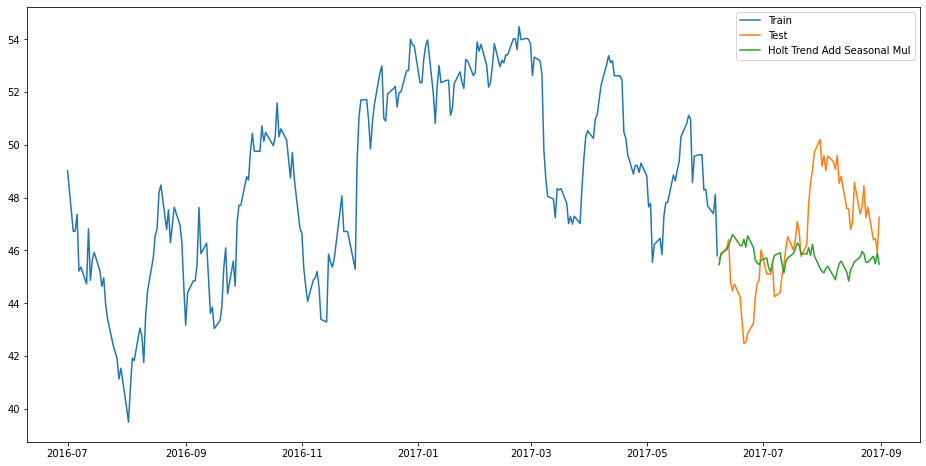

In [ ]:
# visualisasi hasil forecast dari model HoltWinters dengan data aktual
plt.figure(figsize=(16,8))
plt.plot(train['dcoilwtico'], label='Train')
plt.plot(test['dcoilwtico'], label='Test')
plt.plot(data_Holt['Holt'], label='Holt Trend Add Seasonal Mul')
plt.legend(loc=0)

> **Keterangan:**

* Dari grafik di atas terlihat bahwa model Holt-winters mulai melakukan prediksi pd 2017-06 s/d 2019-09 yang ditunjukkan oleh garis berwarna hijau.

* Garis berwarna biru merupakan data yang digunakan untuk train dan garis berwarna oranye yang digunakan untuk test.

In [ ]:
# Evaluation
# Hitung MAE pada model HoltWinters menggunakan function yang dibuat dari awal
def mean_absolute_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

# Hitung MAPE pada model HoltWinters
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Hitung MSE dan RMSE pada model HoltWinters
mse = ((test['dcoilwtico'] - data_Holt['Holt']) ** 2).mean()
rmse = np.sqrt(mse)

print('Mean Absolute Error of our forecasts is ', mean_absolute_error(test['dcoilwtico'],data_Holt['Holt']).round(3))
print('Mean Absolute Percentage Error of our forecasts is ', mean_absolute_percentage_error(test['dcoilwtico'],data_Holt['Holt']).round(2), ' %')
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 3)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 3)))

Mean Absolute Error of our forecasts is  1.843
Mean Absolute Percentage Error of our forecasts is  3.92  %
The Mean Squared Error of our forecasts is 5.475
The Root Mean Squared Error of our forecasts is 2.34


####5.2 SARIMAX

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [ ]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None
train_log = np.log10(train['dcoilwtico'])

In [ ]:
for param in pdq: #Non-Seasonal
    for param_seasonal in seasonal_pdq:

        try:
            temp_model = sm.tsa.statespace.SARIMAX(train_log,
                                             order = param, # (0,1,0) -> (p,d,q)
                                             seasonal_order = param_seasonal) # (0,1,0,12)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal #Store the best param values : AIC, P, D, Q [Non-S / Seas]
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 model - AIC:-1610.1105126255343


In [ ]:
# tampilkan hasil dari SARIMAX
mod = sm.tsa.statespace.SARIMAX(train_log,
                                order=(0,1,0), #p ->AR, q -> MA, d -> diff | pdq
                                seasonal_order=(0,0,0,12),
                                enforce_stationarity=True)

best_results = mod.fit()

print(best_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.688e-05   5.41e-06     14.199      0.000    6.63e-05    8.75e-05


In [ ]:
# Terapkan function get_prediction() pada best_results
pred_dynamic = best_results.get_prediction(dynamic=True, full_results=True)
pred_dynamic

In [ ]:
pred_dynamic_ci = pred_dynamic.conf_int()
pred_dynamic_ci

,lower dcoilwtico,upper dcoilwtico
2016-07-01,-1959.963985,1959.963985
2016-07-04,-1959.963985,1959.963985
2016-07-05,-1959.963985,1959.963985
2016-07-06,-1959.963985,1959.963985
2016-07-07,-1959.963985,1959.963985
...,...,...
2017-06-01,-1959.964003,1959.964003
2017-06-02,-1959.964003,1959.964003
2017-06-05,-1959.964003,1959.964003
2017-06-06,-1959.964003,1959.964003


In [ ]:
pred99 = best_results.get_forecast(len(test))
pred99

In [ ]:
# Extract the predicted and true values of our time series
# sales_ts_forecasted = pred_dynamic.predicted_mean
testCopy = test.copy()
testCopy['dcoilwtico_Forecast'] = np.power(10, pred99.predicted_mean)

In [ ]:
testCopy.tail(10)

,dcoilwtico,dcoilwtico_Forecast
date,,
2017-08-18,48.59,45.8
2017-08-21,47.39,45.8
2017-08-22,47.65,45.8
2017-08-23,48.45,45.8
2017-08-24,47.24,45.8
2017-08-25,47.65,45.8
2017-08-28,46.40,45.8
2017-08-29,46.46,45.8
2017-08-30,45.96,45.8


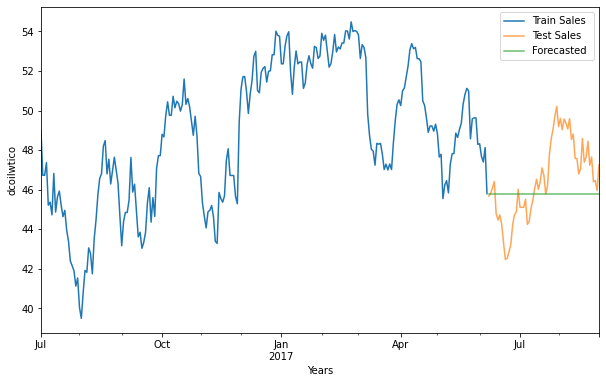

In [ ]:
# visualisasikan dari antara train, test, dan hasil forecast

axis = train['dcoilwtico'].plot(label='Train Sales', figsize=(10, 6))
testCopy['dcoilwtico'].plot(ax=axis, label='Test Sales', alpha=0.7)
testCopy['dcoilwtico_Forecast'].plot(ax=axis, label='Forecasted ', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('dcoilwtico')
plt.legend(loc='best')
plt.show()
plt.close()

In [ ]:
#Evaluation
# Import module metrics dan panggil functionnya
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

y_true = test['dcoilwtico']
y_pred = testCopy['dcoilwtico_Forecast']

print('The Mean Absolute Error of our forecasts is ', mean_absolute_error(y_true, y_pred).round(3))
print ('The Mean Absolute Percentage Error of our forecasts is ', mean_absolute_percentage_error(y_true, y_pred).round(3), '%')
print ('The Mean Squared Error of our forecasts is ', mean_squared_error(y_true, y_pred).round(3))
print ('The Root Mean Squared Error of our forecasts is ', np.sqrt(mean_squared_error(y_true, y_pred)).round(3))

The Mean Absolute Error of our forecasts is  1.687
The Mean Absolute Percentage Error of our forecasts is  0.036 %
The Mean Squared Error of our forecasts is  4.337
The Root Mean Squared Error of our forecasts is  2.083


####5.3 ARIMA

In [ ]:
!pip install pmdarima

In [ ]:
#Importing required Libraries
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#ARIMA Forecast
#Finding the best values for p,q,d,P,Q,D

auto_arima(data['dcoilwtico'], seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  305
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -405.771
Date:                Tue, 26 Apr 2022   AIC                            813.542
Time:                        04:25:38   BIC                            817.259
Sample:                             0   HQIC                           815.029
                                - 305                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.8451      0.054     15.683      0.000       0.739       0.951
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                19.37
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Train-Test split

train_data = data[:len(data)-12]
test_data = data[len(data)-12:]
arima_model = SARIMAX(train_data['dcoilwtico'], order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                 dcoilwtico   No. Observations:                  293
Model:             SARIMAX(2, 1, 1)x(4, 0, [1, 2, 3], 12)   Log Likelihood                -387.016
Date:                                    Tue, 26 Apr 2022   AIC                            796.032
Time:                                            04:26:15   BIC                            836.476
Sample:                                        07-01-2016   HQIC                           812.232
                                             - 08-15-2017                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8493      0.437     -1.944      0.052      -1.705       0.007
ar.L2         -0.0092      0.068     -0.135      0.893      -0.143       0.125
ma.L1          0.8631      0.430      2.006      0.045       0.020       1.706
ar.S.L12      -1.0661      0.803     -1.328      0.184      -2.640       0.507
ar.S.L24       0.3823      1.048      0.365      0.715      -1.672       2.437
ar.S.L36       0.6921      0.475      1.457      0.145      -0.239       1.623
ar.S.L48       0.0382      0.131      0.292      0.770      -0.218       0.294
ma.S.L12       1.0251      0.796      1.288      0.198      -0.535       2.585
ma.S.L24      -0.3553      1.026     -0.346      0.729      -2.366       1.656
ma.S.L36      -0.5730      0.507     -1.130      0.258      -1.567       0.421
sigma2         0.8233      0.065     12.760      0.000       0.697       0.950
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.24
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Prediction
arima_pred = arima_result.predict(start = len(train_data), end = len(data)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2017-08-16    47.670589
2017-08-17    47.624946
2017-08-18    47.431019
2017-08-21    47.500429
2017-08-22    47.450290
2017-08-23    47.394811
2017-08-24    47.406720
2017-08-25    47.460453
2017-08-28    47.528839
2017-08-29    47.620653
2017-08-30    47.539873
2017-08-31    47.590867
Freq: B, Name: ARIMA Predictions, dtype: float64

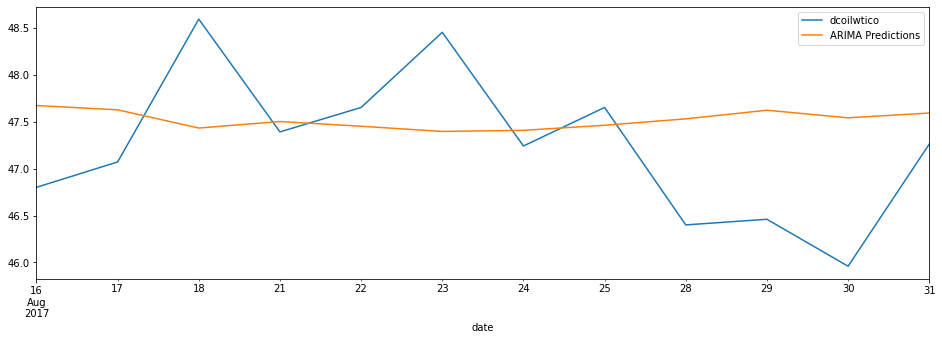

In [ ]:
test_data['dcoilwtico'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [ ]:
#Model Evaluation
arima_rmse_error = rmse(test_data['dcoilwtico'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = data['dcoilwtico'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 0.7387681671017584
RMSE Error: 0.859516240161731
Mean: 48.29629508196718


In [ ]:
test_data['ARIMA_Predictions'] = arima_pred

####5.3 Prophet

In [ ]:
data_pr = data.copy()
data_pr = data.reset_index()
data_pr.columns = ['ds','y'] # To use prophet column names should be like that
train_data_pr = data_pr.iloc[:len(data)-12]
test_data_pr = data_pr.iloc[len(data)-12:]

In [ ]:
from fbprophet import Prophet
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=12,freq='MS')
prophet_pred = m.predict(future)
prophet_pred.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
300,2018-04-01,40.926132,37.404216,48.714476,36.242189,45.777791,2.144854,2.144854,2.144854,2.144854,2.144854,2.144854,0.0,0.0,0.0,43.070986
301,2018-05-01,40.149643,33.324676,45.565781,34.356748,45.942211,-0.861092,-0.861092,-0.861092,-0.861092,-0.861092,-0.861092,0.0,0.0,0.0,39.288550
302,2018-06-01,39.347270,30.983198,45.992481,32.568805,46.213604,-0.733080,-0.733080,-0.733080,-0.733080,-0.733080,-0.733080,0.0,0.0,0.0,38.614190
303,2018-07-01,38.570781,32.066987,49.237377,30.643015,46.425575,2.144854,2.144854,2.144854,2.144854,2.144854,2.144854,0.0,0.0,0.0,40.715635
304,2018-08-01,37.768408,27.316182,46.335019,28.536684,46.676497,-0.940777,-0.940777,-0.940777,-0.940777,-0.940777,-0.940777,0.0,0.0,0.0,36.827631


In [ ]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "MS"
prophet_pred

,Pred
Date,
2017-09-01,45.680243
2017-10-01,47.781688
2017-11-01,43.893685
2017-12-01,43.324892
2018-01-01,42.373444
2018-02-01,41.580625
2018-03-01,40.855902
2018-04-01,43.070986
2018-05-01,39.288550


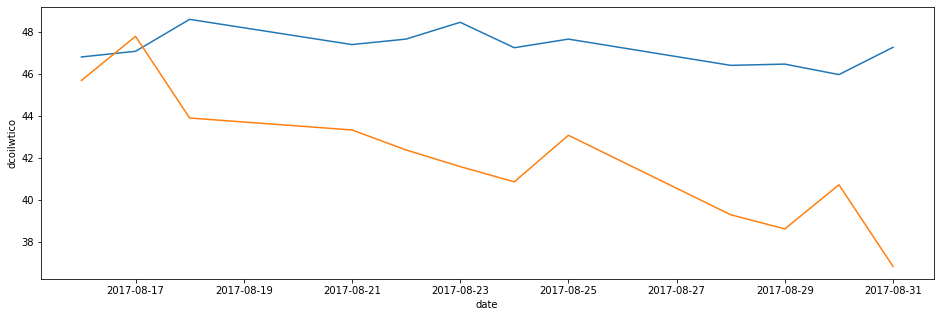

In [ ]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values
import seaborn as sns
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_data.index, y=test_data["dcoilwtico"])
sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"]);

In [ ]:
prophet_rmse_error = rmse(test_data['dcoilwtico'], test_data["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = data['dcoilwtico'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 35.46353370327092
RMSE Error: 5.955126673990312
Mean: 48.29629508196718


###6. Model Evaluation
> Pada tahap ini, kita akan membandingkan model yang paling baik untuk digunakan dengan melihat nilai error yang terkecil.



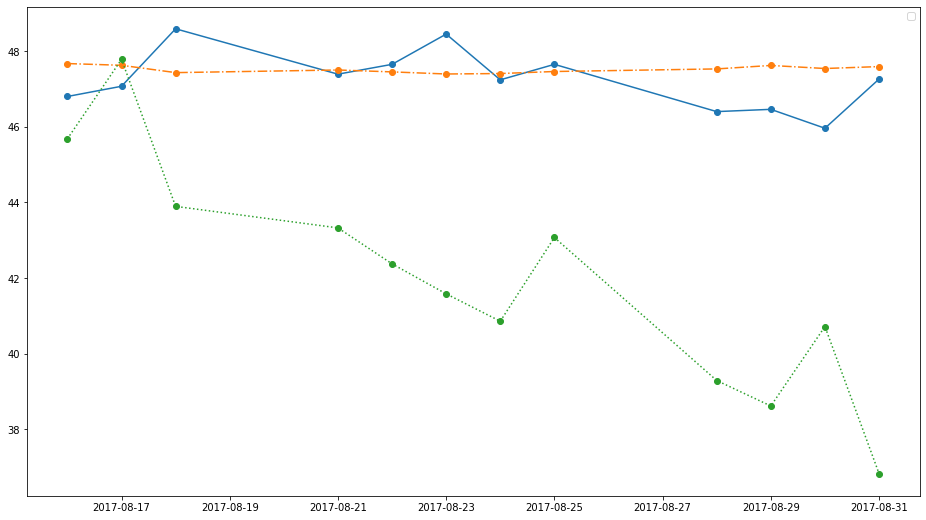

In [ ]:
#Comparison

rmse_errors = [arima_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["dcoilwtico"], linestyle="-")
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.")
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":")
plt.legend()
plt.show()

In [ ]:
print(f"Mean: {test_data['dcoilwtico'].mean()}")
errors

Mean: 47.24333333333333


,Models,RMSE Errors,MSE Errors
0,ARIMA,0.859516,0.738768
1,Prophet,5.955127,35.463534


**Insight:**
- Model yang paling baik untuk dipilih adalah ARIMA karena memiliki nilai RMSE Error yang jauh lebih kecil daripada model lainnya.